# モデリング

In [33]:
import pandas as pd
import numpy as np
import datetime
import japanize_matplotlib
import statsmodels.api as sm
import pmdarima as pm
import matplotlib.pyplot as plt
from pmdarima import arima
from pmdarima import model_selection
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [34]:
plt.style.use('fast')# スタイルの設定
plt.rcParams['figure.figsize'] = [9, 5]# サイズの設定

file_path = "../data/BloodDonation.csv"
df = pd.read_csv(file_path)
# date列を作成
df['date'] = pd.to_datetime((df['year'].astype(str)) + '-' + (df['month'].astype(str)))

# dateごとの全国のblood_donorsでグループ化
grouped_date_total = df.groupby(['date'])['blood_donors'].sum().to_frame()
grouped_date_total 

,blood_donors
date,
2017-01-01,406899
2017-02-01,390045
2017-03-01,411315
2017-04-01,390606
2017-05-01,402952
...,...
2023-12-01,439527
2024-01-01,428615
2024-02-01,401239


### SARIMAモデル

**SARIMA(p, d, q)(P, D, Q, s)**<br>
p = 自己回帰, d = 和分, q = 移動平均<br>
P = 季節性の自己回帰, D = 季節性の和分, Q = 季節性の移動平均, s = 季節性の周期<br>

- 自己回帰：現在の値が過去の値のどれだけに依存するか
- 和分：系列データのを定常化するために差分をとる回数
- 移動平均：過去の誤差が将来の値にどれだけ影響するか

In [35]:
# 最適パラメータ探索

# 学習データとテストデータ（直近12ヶ月間）に分割
train_size = len(grouped_date_total) - 12
df_train = grouped_date_total.iloc[:train_size]

# SARIMAモデルの自動パラメータ探索
smodel = pm.auto_arima(df_train, start_p=0, start_q=0, max_p=4, max_q=4, 
                       seasonal=True, m=12, start_P=0, start_Q=0, 
                       max_P=4, max_Q=4, d=1, D=1, trace=True,
                       error_action='ignore', suppress_warnings=True, 
                       stepwise=True)

# 選択されたモデルのサマリー
print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1406.214, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1408.423, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1412.075, Time=0.07 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1406.478, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1406.515, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1407.906, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1412.027, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1414.185, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=1407.514, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.649 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   76
Model:             SARIMAX(0, 1,

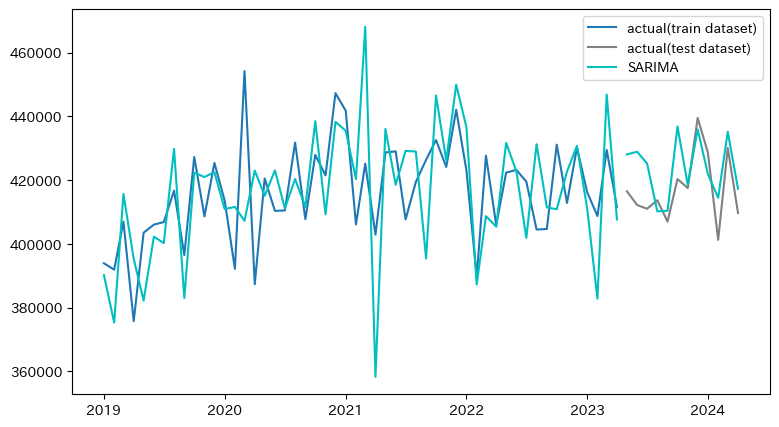

RMSE:  10117.15204491857
MAE:  8592.666666666666
MAPE:  0.020711765602020024
                                     SARIMAX Results                                      
Dep. Variable:                       blood_donors   No. Observations:                   76
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -702.107
Date:                            Thu, 27 Jun 2024   AIC                           1406.214
Time:                                    01:06:10   BIC                           1408.357
Sample:                                01-01-2017   HQIC                          1407.057
                                     - 04-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.403e+08   3.12e+07     

In [45]:
# 学習データとテストデータ（直近12ヶ月間）に分割
df_train, df_test = model_selection.train_test_split(grouped_date_total, test_size=12)

# 原系列を学習データとする
train = df_train

# 学習
sarima_model = SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 1, 0, 12))
sarima_fit = sarima_model.fit()

# 予測
#学習データの期間の予測値
train_pred = sarima_fit.predict()
#テストデータの期間の予測値
test_pred = sarima_fit.forecast(len(df_test))
#予測区間
test_pred_ci = sarima_fit.get_forecast(len(df_test)).conf_int() 

# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, train_pred[24:].values, color="c")
ax.plot(df_test.index, test_pred.values, label="SARIMA", color="c") 
#ax.fill_between(df_test.index, test_pred_ci.iloc[:, 0], test_pred_ci.iloc[:, 1], color='c', alpha=.2)
ax.legend()
plt.show()

# テストデータで精度検証
print('RMSE: ',np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE: ',mean_absolute_error(df_test, test_pred)) 
print('MAPE: ',mean_absolute_percentage_error(df_test, test_pred))

print(sarima_fit.summary())

RMSE:予測誤差の二乗平均の平方根<br>
MAE:予測誤差の絶対値の平均<br>
MAPE:予測誤差の割合の絶対値の平均<br>

増加・減少の傾向はある程度とらえることができているのでは

#### 参考にしたサイト等
https://momonoki2017.blogspot.com/2018/03/python9sarima.html<br>
https://www.salesanalytics.co.jp/datascience/datascience087/#pdq_PDQm<br>
https://qiita.com/KENTAROSZK/items/a8d25122a9659967d9f4<br>
https://blog.since2020.jp/data_analysis/arima%E3%83%A2%E3%83%87%E3%83%AB%E3%81%A7%E6%99%82%E7%B3%BB%E5%88%97%E4%BA%88%E6%B8%AC%E3%82%92%E3%82%84%E3%81%A3%E3%81%A6%E3%81%BF%E3%82%8B/<br>
